# Classical Steps Shor's Algorithm

In [2]:
# Brute force period finding

def find_period_classical(a, N):
    n = 1
    t = a
    while t != 1:
        t *= a
        t %= N
        n += 1
    return n

For simplicity, assume that N has only two distinct prime factors: N = p*q

1. Pick a random integer $a$ between 1 and N and compute the greatest common divisor gcd(a,N) using Euclid's algorithm.

2. If a and N have some common prime factors, gcd(a,N) will equal p or q. Otherwise gcd(a,N) = 1, meaning x and N are coprime

3. Let r be the period of a mod N computed by the period finding machine. Repeat the above steps with different random choices  a until r is even

4. Now p and q can be found by computing gcd(a^{r/2} -1, N) && gcd(a^{r/2} +1, N) 

In [3]:
r = find_period_classical(4, 15)
print(r)

2


In [4]:
a = 4

p = a**(r/2)+1 
q = a**(r/2)-1


print(q)
print(p)

3.0
5.0


# Now implementation of Shor's Algorithm classical:

In [5]:
import math,random, itertools

def shors_algorithm_classical(N):
    x = random.randint(0,N)
    if(math.gcd(x,N) != 1): # step one, pick a number bigger 1 smaller N
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    
    r = find_period_classical(x,N) # step two find the period (Bottleneck)
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    
    p = math.gcd(x**int(r/2)+1,N) # step three compute the factor 
    q = math.gcd(x**int(r/2)-1,N) # step three compute the factor
    return x,r,p,q



In [9]:
N = 15
x,r,p,q = shors_algorithm_classical(N)
print("period r = ",r,", prime factors = ",p," and ",q,sep="")

period r = 4, prime factors = 5 and 3


# Implementation based on the following https://github.com/amitabhyadav/Shor-Algorithm-on-IBM-Quantum-Experience

In [3]:
# Imports 
from qiskit import Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

In [4]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_amod15(qc,qr,cr,a):
    if a == 2:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
    elif a == 7:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 8:
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[3],qr[2])
    elif a == 11: # this is included for completeness
        qc.cswap(qr[4],qr[2],qr[0])
        qc.cswap(qr[4],qr[3],qr[1])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])
    elif a == 13:
        qc.cswap(qr[4],qr[3],qr[2])
        qc.cswap(qr[4],qr[2],qr[1])
        qc.cswap(qr[4],qr[1],qr[0])
        qc.cx(qr[4],qr[3])
        qc.cx(qr[4],qr[2])
        qc.cx(qr[4],qr[1])
        qc.cx(qr[4],qr[0])

In [5]:
# qc = quantum circuit, qr = quantum register, cr = classical register, a = 2, 7, 8, 11 or 13
def circuit_aperiod15(qc,qr,cr,a):
    if a == 11:
        circuit_11period15(qc,qr,cr)
        return
    
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled unitary
    qc.cx(qr[4],qr[2])
    qc.cx(qr[4],qr[0])
    #   feed forward
    if cr[0] == 1:
        qc.u1(math.pi/2.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a mod 15
    qc.h(qr[4])
    #   controlled unitary.
    circuit_amod15(qc,qr,cr,a)
    #   feed forward
    if cr[1] == 1:
        qc.u1(math.pi/2.,qr[4])
    if cr[0] == 1:
        qc.u1(math.pi/4.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

In [6]:
def circuit_11period15(qc,qr,cr):
    # Initialize q[0] to |1> 
    qc.x(qr[0])

    # Apply a**4 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[0])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply a**2 mod 15
    qc.h(qr[4])
    #   controlled identity on the remaining 4 qubits, which is equivalent to doing nothing
    #   feed forward
    if cr[0] == 1:
        qc.u1(math.pi/2.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[1])
    #   reinitialise q[4] to |0>
    qc.reset(qr[4])

    # Apply 11 mod 15
    qc.h(qr[4])
    #   controlled unitary.
    qc.cx(qr[4],qr[3])
    qc.cx(qr[4],qr[1])
    #   feed forward
    if cr[1] == 1:
        qc.u1(math.pi/2.,qr[4])
    if cr[0] == 1:
        qc.u1(math.pi/4.,qr[4])
    qc.h(qr[4])
    #   measure
    qc.measure(qr[4],cr[2])

a = 7 for this example 

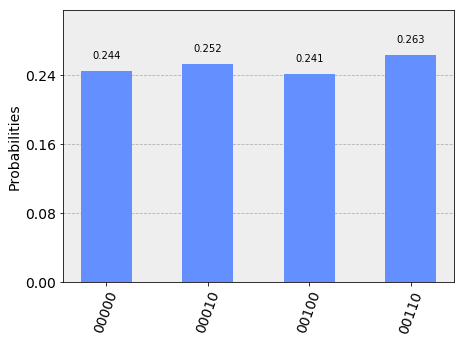

In [12]:
q = QuantumRegister(5, 'q')
c = ClassicalRegister(5, 'c')
a = 13

shor = QuantumCircuit(q, c)
wqe = circuit_aperiod15(shor,q,c,a) # circuit for a = 7, and plot the results:

backend = Aer.get_backend('qasm_simulator')
sim_job = execute([shor], backend)
sim_result = sim_job.result()
sim_data = sim_result.get_counts(shor) 
plot_histogram(sim_data)
